In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from google.colab import drive
from sklearn.linear_model import LinearRegression as LR
from scipy.optimize import minimize
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive/')

US_NEWS_2020_PATH = "/content/drive/MyDrive/6.S079_Project/data/us_news_2020.csv"
WEIGHTS_2020_PATH = "/content/drive/MyDrive/6.S079_Project/data/2020_weights.csv"

act_percentiles_2020 = {36: 100, 35: 99, 34: 99, 33: 97, 32: 96, 31: 94, 30: 92, 29: 90, 28: 88, 27: 85, 26: 82, 25: 78, 24: 74, 23: 70, 22: 65, 21: 60, 20: 54, 19: 48, 18: 42, 17: 36, 16: 30, 15: 24, 14: 17, 13: 11, 12: 6, 11: 2, 10: 1, 9: 1, 8: 1, 7: 1, 6: 1, 5: 1, 4: 1, 3: 1, 2: 1, 1: 1}

sat_percentiles_2020 = {1600: 100, 1590: 100, 1580: 100, 1570: 100, 1560: 100, 1550: 99, 1540: 99, 1530: 99, 1520: 99, 1510: 98, 1500: 98, 1490: 98, 1480: 97, 1470: 97, 1460: 97, 1450: 96, 1440: 96, 1430: 95, 1420: 95, 1410: 94, 1400: 94, 1390: 93, 1380: 92, 1370: 92, 1360: 91, 1350: 90, 1340: 89, 1330: 89, 1320: 88, 1310: 87, 1300: 86, 1290: 85, 1280: 84, 1270: 83, 1260: 82, 1250: 81, 1240: 80, 1230: 78, 1220: 77, 1210: 76, 1200: 74, 1190: 73, 1180: 72, 1170: 70, 1160: 69, 1150: 67, 1140: 66, 1130: 64, 1120: 62, 1110: 61, 1100: 59, 1090: 57, 1080: 55, 1070: 54, 1060: 52, 1050: 50, 1040: 48, 1030: 46, 1020: 45, 1010: 43, 1000: 41, 990: 39, 980: 38, 970: 36, 960: 34, 950: 33, 940: 31, 930: 29, 920: 28, 910: 26, 900: 25, 890: 23, 880: 22, 870: 20, 860: 19, 850: 18, 840: 16, 830: 15, 820: 14, 810: 12, 800: 11, 790: 10, 780: 9, 770: 8, 760: 7, 750: 6, 740: 5, 730: 5, 720: 4, 710: 3, 700: 3, 690: 2, 680: 2, 670: 1, 660: 1, 650: 1, 640: 1, 630: 1, 620: 1, 610: 1, 600: 1}


Mounted at /content/drive/


In [3]:
us_news_2020 = pd.read_csv(US_NEWS_2020_PATH)
weights_2020 = pd.read_csv(WEIGHTS_2020_PATH)
display(us_news_2020)

,2020 Rank,School,Public/Private,Overall Score,Peer Assessment Score,Graduation and retention rank,Average first year retention rate,Average first year retention rate footnote,Predicted graduation rate,Actual graduation rate,...,Student/faculty ratio footnote,Selectivity rank,SAT/ACT 25th-75th percentile,SAT/ACT 25th-75th percentile footnote,First year students in top 10% of high school class,First year students in top 10% of high school class footnote,Acceptance rate,Financial resources rank,Average alumni giving rate,Average alumni giving rate footnote
0,1,Princeton University (NJ),private,100,4.9,2,98%,NaN,95%,96%,...,NaN,11,1440-1570,NaN,91%,4.0,5%,12,59%,NaN
1,2,Harvard University (MA),private,96,4.9,2,97%,NaN,97%,98%,...,NaN,2,1460-1580,NaN,94%,NaN,5%,8,31%,NaN
2,3,Columbia University (NY),private,94,4.7,4,99%,NaN,94%,96%,...,NaN,2,1450-1560,NaN,96%,NaN,6%,13,30%,NaN
3,3,Massachusetts Institute of Technology,private,94,4.9,10,99%,NaN,95%,94%,...,NaN,2,1500-1570,NaN,97%,NaN,7%,2,33%,NaN
4,3,Yale University (CT),private,94,4.8,1,99%,NaN,97%,97%,...,NaN,2,1450-1560,NaN,95%,NaN,6%,1,27%,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,281,Sam Houston State University (TX),public,27,2.2,278,78%,NaN,47%,53%,...,NaN,323,1000-1140,NaN,19%,4.0,79%,365,7%,NaN
288,281,Univ. of Missouri--St. Louis,public,27,2.4,283,76%,NaN,63%,52%,...,NaN,184,21-27,NaN,26%,NaN,73%,294,4%,NaN
289,281,University of North Florida,public,27,2.4,230,81%,NaN,61%,59%,...,NaN,184,1120-1280,NaN,16%,NaN,61%,339,4%,NaN
290,281,University of North Texas,public,27,2.6,261,79%,NaN,55%,55%,...,NaN,215,1060-1260,NaN,19%,NaN,71%,376,4%,NaN


In [4]:
clean_dict = {
    '2020 Rank': ['rank', 'int'],
    'School' : ['school', 'str'],
    'Overall Score': ['score', 'int'],
    'Peer Assessment Score': ['peer_score', 'float64'],
    'Graduation and retention rank': ['graduation_retention_rank', 'int'],
    'Over/Underperformance': ['graduation_diff', 'int'],
    'Social Mobility Rank': ['social_mobility_rank', 'int'],
    'Faculty resources rank': ['faculty_resources_rank', 'int'],
    'SAT/ACT 25th-75th percentile': ['test_scores', 'range'],
    'First year students in top 10% of high school class': ['accomplished_freshman', 'pct'],
    'Financial resources rank': ['financial_resources_rank', 'int'],
    'Average alumni giving rate': ['alum_giving_rate', 'pct'],
}

In [5]:
def ratio_converter(ratio_str):
  numerator, denominator = map(float, ratio_str.split(' to '))
  return numerator / denominator if denominator != 0 else None

def range_converter(range_str):
  if type(range_str) == str:
    bottom, top = map(float, range_str.split('-'))
    # converts the top and bottom range to the ACT/SAT Percentiles for the year 2020
    if top <= 36:
      bottom = act_percentiles_2020[bottom]
      top = act_percentiles_2020[top]
    else:
      bottom = sat_percentiles_2020[round(bottom, -1)]
      top = sat_percentiles_2020[round(top, -1)]
    return (bottom + top)/2
  else: # in case of 'nan' values
     return range_str

def rank_converter(df, col):
  max_rank = df[col].max()
  df[col] = (max_rank + 1 - df[col]) / max_rank
  return df

def clean_2020_data(df, trans_dic):
  for col in df.columns:
    try:
      _name, _type = trans_dic[col]
      df = df.rename(columns={col: _name})
      if _type in ['int', 'float64']:
        df[_name] = pd.to_numeric(df[_name], errors='coerce')
      elif _type == 'str':
        df[_name] = df[_name].astype('str')
      elif _type == 'pct':
        df[_name] = df[_name].str.rstrip('%').astype(float) / 100
      elif _type == 'ratio':
        df[_name] = df[_name].apply(ratio_converter)
      elif _type == 'range':
        df[_name] = df[_name].apply(range_converter)
    except:
      df = df.drop(columns=col)

  #==========================================
  # CONTEXT DEPENDENT (i.e 2020) TRANSFORMATIONS
  #==========================================
  # 'NaN' represents a difference of 0
  df['graduation_diff'] = df['graduation_diff'].fillna(0)

  # convert ranks
  df = rank_converter(df, 'social_mobility_rank')
  df = rank_converter(df, 'faculty_resources_rank')
  df = rank_converter(df, 'graduation_retention_rank')

  # apply z-score to standardize scores as described by U.S News
  df = pd.concat([df[['school', 'rank', 'score']], df.drop(columns=['score', 'school', 'rank']).dropna().apply(zscore)], axis=1)
  #==========================================

  return df

In [12]:
college_df = clean_2020_data(us_news_2020, clean_dict)
clean_2020_df = clean_2020_data(us_news_2020, clean_dict)
display(college_df)

,school,rank,score,peer_score,graduation_retention_rank,graduation_diff,social_mobility_rank,faculty_resources_rank,test_scores,accomplished_freshman,financial_resources_rank,alum_giving_rate
0,Princeton University (NJ),1,100,2.569441,1.596914,-0.086632,0.048778,1.467564,1.628057,2.004659,-1.437574,5.510191
1,Harvard University (MA),2,96,2.569441,1.596914,-0.086632,0.048778,1.477266,1.667244,2.121233,-1.478316,2.275921
2,Columbia University (NY),3,94,2.299390,1.574301,0.082300,0.471525,1.506371,1.628057,2.198948,-1.427388,2.160411
3,Massachusetts Institute of Technology,3,94,2.569441,1.506462,-0.424495,-0.435618,1.448161,1.706431,2.237806,-1.539429,2.506940
4,Yale University (CT),3,94,2.434416,1.608221,-0.255564,-0.823136,1.428758,1.628057,2.160090,-1.549614,1.813882
...,...,...,...,...,...,...,...,...,...,...,...,...
287,Sam Houston State University (TX),281,27,-1.076247,-1.523691,0.758027,0.947114,-1.569022,-1.859591,-0.793096,2.157909,-0.496311
288,Univ. of Missouri--St. Louis,281,27,-0.806196,-1.580224,-2.113814,0.841428,-1.180960,-0.370483,-0.521092,1.434738,-0.842840
289,University of North Florida,281,27,-0.806196,-0.980977,-0.593427,0.674091,-1.976487,-0.331296,-0.909669,1.893086,-0.842840
290,University of North Texas,281,27,-0.536145,-1.331480,-0.255564,0.841428,-1.976487,-0.801541,-0.793096,2.269950,-0.842840


**First Order analysis**: regress the weights. Not terrible, but not great either.

In [7]:
def linear_regression(df):
  df = df.dropna()
  X = df.drop(columns=['school','rank', 'score'])
  y = df['score']
  model = LR()
  model.fit(X, y)
  print(X.columns)
  print("Coefficients:", model.coef_)
  print("Intercept:", model.intercept_)
  predictions = np.round(model.predict(X))
  df['pred_score'] = predictions
  df['pred_rank'] = df['pred_score'].rank(method="min", ascending=False)

  return df

lr_df = linear_regression(college_df)
display(lr_df[['school', 'rank', 'pred_rank', 'score', 'pred_score']])

Index(['peer_score', 'graduation_retention_rank', 'graduation_diff',
       'social_mobility_rank', 'faculty_resources_rank', 'test_scores',
       'accomplished_freshman', 'financial_resources_rank',
       'alum_giving_rate'],
      dtype='object')
Coefficients: [ 6.79719493  3.91728541  1.51809442  1.19614095  2.41900444  0.32356589
  2.73238212 -1.45889703  2.80671381]
Intercept: 48.86446886446886


<ipython-input-7-17abb6f38382>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_score'] = predictions
<ipython-input-7-17abb6f38382>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_rank'] = df['pred_score'].rank(method="min", ascending=False)


,school,rank,pred_rank,score,pred_score
0,Princeton University (NJ),1,1.0,100,100.0
1,Harvard University (MA),2,2.0,96,91.0
2,Columbia University (NY),3,4.0,94,90.0
3,Massachusetts Institute of Technology,3,2.0,94,91.0
4,Yale University (CT),3,9.0,94,88.0
...,...,...,...,...,...
287,Sam Houston State University (TX),281,259.0,27,27.0
288,Univ. of Missouri--St. Louis,281,266.0,27,26.0
289,University of North Florida,281,259.0,27,27.0
290,University of North Texas,281,250.0,27,28.0


**Second Order Analysis** Read into the USNCR using z-scores for each category, not simply calculating a score based off of a weighted average.

**From an older revision of Wikipedia:**




*The following are elements in the U.S. News rankings as of the 2020 edition.*



*   *Peer assessment: a survey of the institution's reputation among presidents, provosts, and admissions deans of other institutions (20%)*
*   *Retention: six-year graduation rate and first-year student retention rate (22%)*
*   *Social mobility: six-year graduation rates of students receiving Pell Grants—both as a standalone measure and compared to graduation rates of all other students at the school—adjusted significantly to give more credit to schools enrolling larger proportions of students receiving Pell Grants. (5%)*
*   *Faculty resources: class sizes, faculty salary, faculty degree level, student-faculty ratio, and proportion of full-time faculty (20%)*
*   *Student excellence: standardized test scores of admitted students and proportion of admitted students in upper percentiles of their high school class.* (unstated; by remainder --> 10%)
*   *Financial resources: per-student spending related to academics, student support and public service. (10%)*
*   *Graduation rate performance: comparison between modeled expected and actual graduation rate (8%)*
*   *Alumni giving rate (5%)*






In [8]:
weights = {
    'peer_score': 0.2,
    'graduation_retention_rank': 0.22,
    'social_mobility_rank': 0.05,
    'faculty_resources_rank': 0.2,
    'graduation_diff': 0.08,
    'test_scores': 0.075,                # this and one below account for 'Student Excellence (10%)'
    'accomplished_freshman': 0.025,
    'financial_resources_rank': 0.1,
    'alum_giving_rate': 0.05,
    }

def min_max_scale(data, new_min, new_max):
    old_min = min(data)
    old_max = max(data)
    scaled_data = new_min + ((data - old_min) * (new_max - new_min) / (old_max - old_min))
    return scaled_data

def calculate_weighted_average_score(df):
  df['pred_score'] = 0
  for col, weight in weights.items():
    # print(f"{col}\n{df[col].dtype}\n")
    df['pred_score'] = df['pred_score'] + df[col] * weight
    # print(f"{df['pred_score']}\n\n")
  df['pred_score'] = df['pred_score'] / df['pred_score'].max() * 100
  df['pred_score'] = min_max_scale(df['pred_score'], 27, 100)
  df['pred_rank'] = df['pred_score'].rank(method="min", ascending=False)
  return df

weighted_avg_df = calculate_weighted_average_score(college_df)
display(weighted_avg_df[['school', 'rank', 'pred_rank', 'score', 'pred_score']])

,school,rank,pred_rank,score,pred_score
0,Princeton University (NJ),1,1.0,100,100.000000
1,Harvard University (MA),2,2.0,96,95.760595
2,Columbia University (NY),3,3.0,94,95.218812
3,Massachusetts Institute of Technology,3,4.0,94,93.998322
4,Yale University (CT),3,7.0,94,92.445984
...,...,...,...,...,...
287,Sam Houston State University (TX),281,250.0,27,41.429795
288,Univ. of Missouri--St. Louis,281,258.0,27,39.095178
289,University of North Florida,281,245.0,27,42.450665
290,University of North Texas,281,241.0,27,42.923668


In [9]:
top_lr_df = lr_df.head(10)
top_avg_df = weighted_avg_df.head(10)

for replication, _str in [[top_lr_df, 'Top10 LR'],
                          [top_avg_df, 'Top10 Avg'],
                          [lr_df.dropna(), 'All LR'],
                          [weighted_avg_df.dropna(), 'All Avg']]:
  print(f"{_str}: {mean_squared_error(replication['pred_score'], replication['score'])}")

Top10 LR: 20.1
Top10 Avg: 0.9937995024371091
All LR: 3.4395604395604398
All Avg: 170.82468084024921


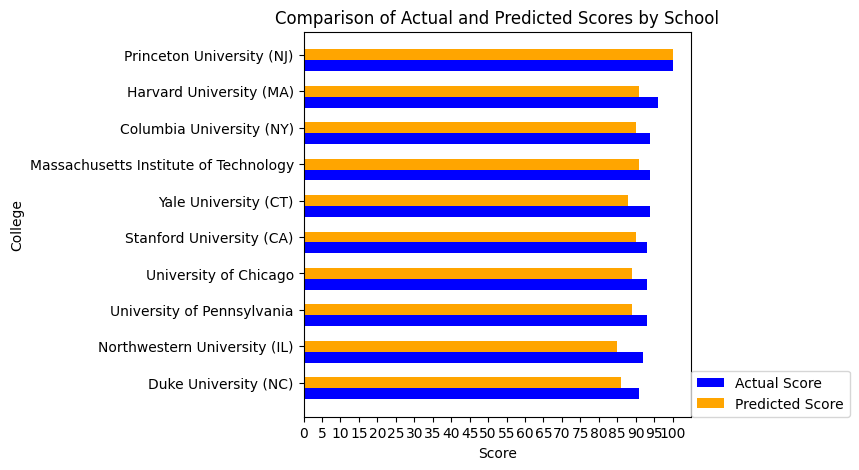

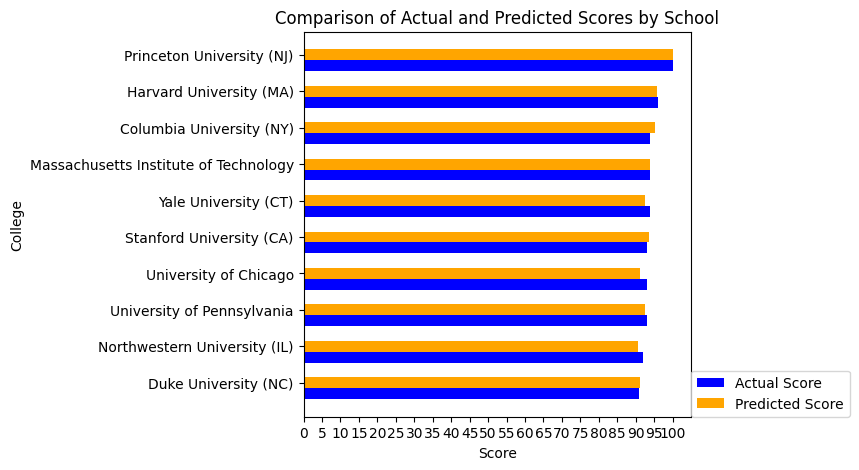

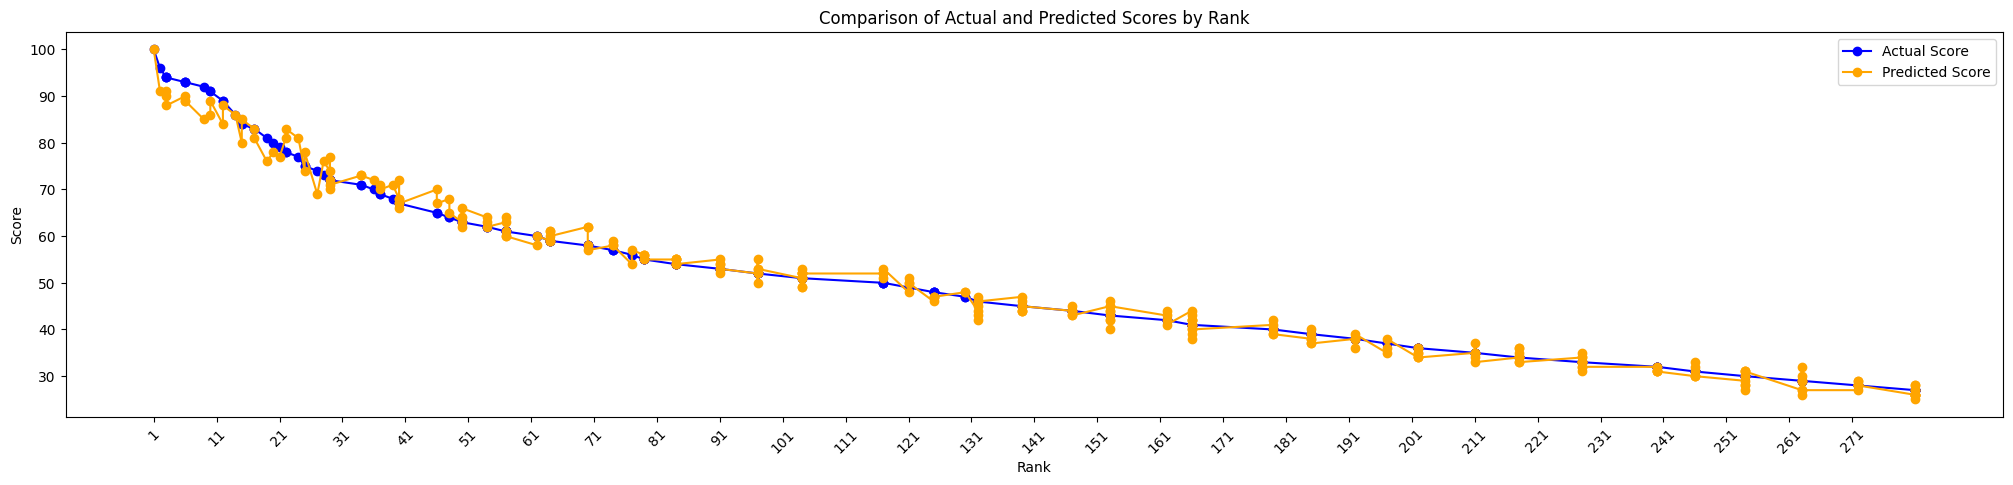

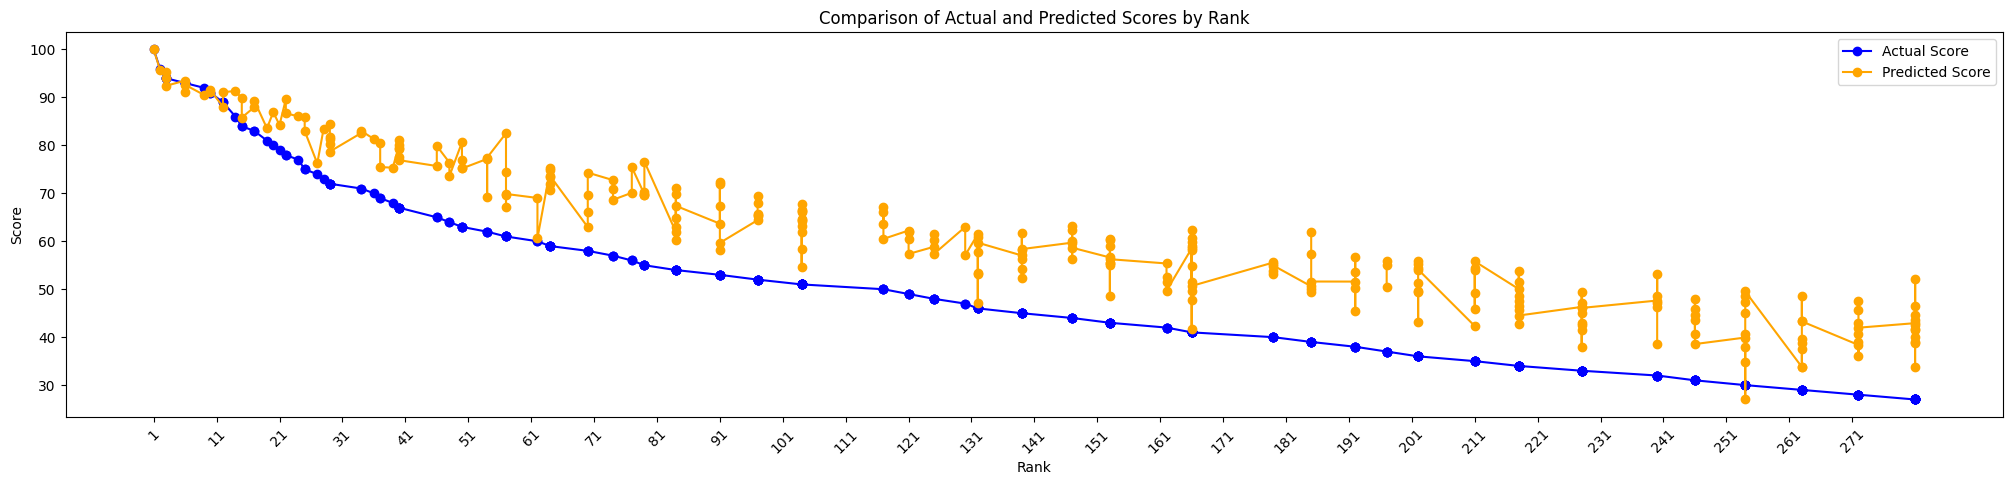

In [10]:
def plot_scores_hbar(df):
  df = df.iloc[::-1].reset_index(drop=True)
  # Set the positions and width for the bars
  positions = list(range(len(df['score'])))
  height = 0.3  # the height of a bar

  fig, ax = plt.subplots(figsize=(5,5))  # Set up the plot size

  # Plotting the bars
  plt.barh([p - height for p in positions], df['score'], height, label='Actual Score', color='blue')
  plt.barh(positions, df['pred_score'], height, label='Predicted Score', color='orange')

  # Adding some aesthetics
  ax.set_title('Comparison of Actual and Predicted Scores by School')
  ax.set_ylabel('College')
  ax.set_xlabel('Score')
  ax.set_xticks([_*5 for _ in range(21)])
  ax.set_yticks([p for p in positions])
  ax.set_yticklabels(df['school'], )

  # Adding a legend
  plt.legend(loc=(1,0))

  # Show the plot
  plt.show()

def plot_scores_line(df):
  df = df.sort_values(by='rank')

  # Plotting the data
  fig, ax = plt.subplots(figsize=(25,5))  # Set up the plot size

  # Plotting the lines
  plt.plot(df['rank'], df['score'], marker='o', label='Actual Score', color='blue')
  plt.plot(df['rank'], df['pred_score'], marker='o', label='Predicted Score', color='orange')

  # Adding some aesthetics
  ax.set_title('Comparison of Actual and Predicted Scores by Rank')
  ax.set_xlabel('Rank')
  ax.set_ylabel('Score')
  plt.xticks(list(range(1, df['rank'].max(), 10)))  # Set x-ticks to be the ranks
  ax.set_xticklabels(list(range(1, df['rank'].max(), 10)), rotation=45)
  # Adding a legend
  plt.legend(loc='best')  # Automatically find the best location for the legend

  # Show the plot
  plt.show()

plot_scores_hbar(top_lr_df)
plot_scores_hbar(top_avg_df)

plot_scores_line(lr_df)
plot_scores_line(weighted_avg_df)


Index(['peer_score', 'graduation_retention_rank', 'graduation_diff',
       'social_mobility_rank', 'faculty_resources_rank', 'test_scores',
       'accomplished_freshman', 'financial_resources_rank',
       'alum_giving_rate'],
      dtype='object')
Coefficients: [ 6.79719493  3.91728541  1.51809442  1.19614095  2.41900444  0.32356589
  2.73238212 -1.45889703  2.80671381]
Intercept: 48.86446886446886


<ipython-input-7-17abb6f38382>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_score'] = predictions
<ipython-input-7-17abb6f38382>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_rank'] = df['pred_score'].rank(method="min", ascending=False)


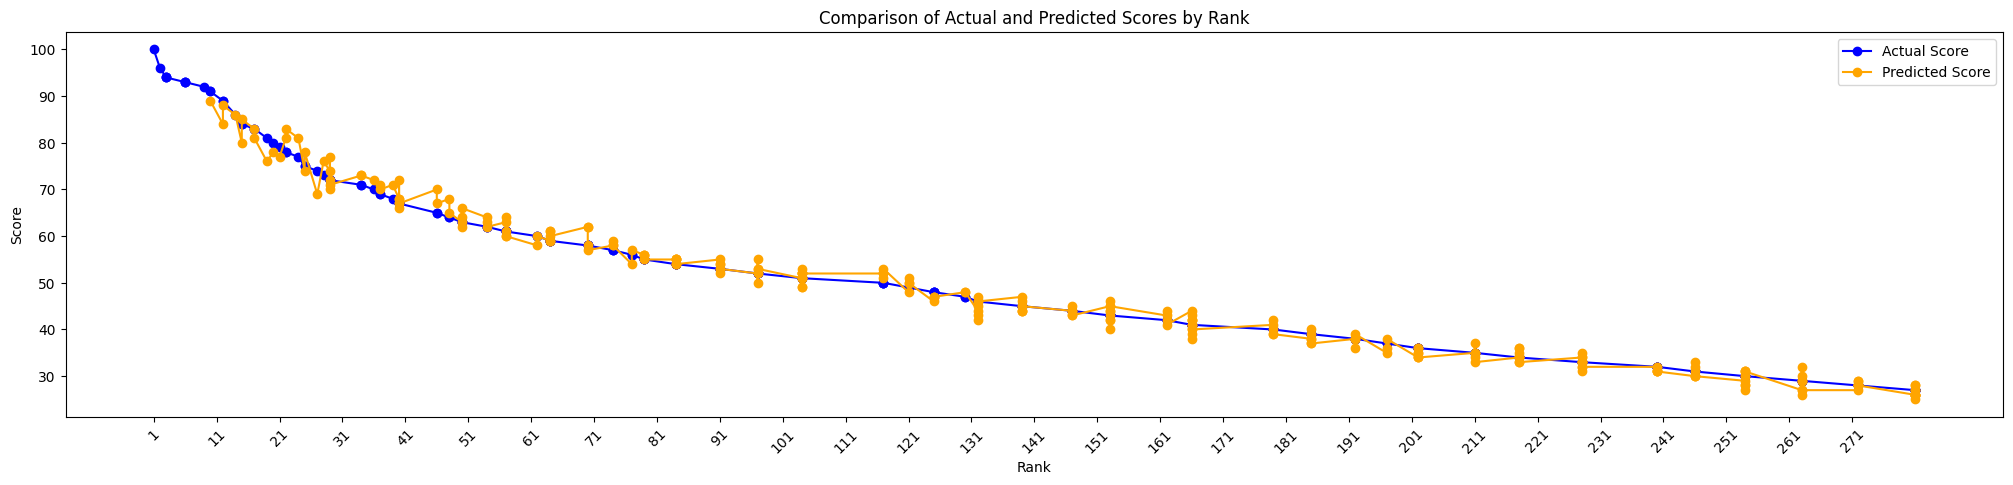

In [13]:
# prompt: First, drop the 'pred_score' column of weighted_avg_df and rename 'dist_score' column to 'pred_scoere'. Concatanate the first 10 rows of weighted_avg_df with everything besides the first 10 rows of linear_regression(clean_2020_df)

import pandas as pd
avg_df_head = weighted_avg_df.drop(columns=['pred_score'])
avg_df_head = avg_df_head.rename(columns={'dist_score': 'pred_score'})
combined_df = pd.concat([avg_df_head.head(10), linear_regression(clean_2020_df).iloc[10:]])

# display(combined_df[['school', 'rank', 'score', 'pred_score']])
# display(weighted_avg_df.drop(columns=['pred_score']).rename(columns={'dist_score': 'pred_score'})[['school', 'rank', 'score', 'pred_score']])

plot_scores_line(combined_df)


Try to use optimization function to determine weights based on matching rankings, initial assumptions, and objective function

In [14]:


df = clean_2020_df
def calculate_score(weights):
    weighted_scores = (df['peer_score'] * weights[0] +
                       df['graduation_retention_rank'] * weights[1] +
                       df['social_mobility_rank'] * weights[2] +
                       df['faculty_resources_rank'] * weights[3] +
                       df['graduation_diff'] * weights[4] +
                       df['test_scores'] * weights[5] +
                       df['accomplished_freshman'] * weights[6] +
                       df['financial_resources_rank'] * weights[7] +
                       df['alum_giving_rate'] * weights[8])
    return weighted_scores

def objective_function(weights):
    estimated_ranks = calculate_score(weights)
    rank_diff = (estimated_ranks - df['rank']).abs()  # Assuming 'rank' is the actual rank column
    return rank_diff.sum()

# Initial guesses for weights
initial_weights = np.array([0.2, 0.22, 0.05, 0.2, 0.08, 0.075, 0.025, 0.1, 0.05])
initial_weights_zero = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])


# constraint is that the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

bounds = [(0, 1)] * 9

result = minimize(objective_function, initial_weights_zero, method='SLSQP', bounds=bounds, constraints=constraints)

if result.success:
    fitted_weights = result.x
    formatted_weights = [f"{weight:.6f}" for weight in fitted_weights]

    print("Optimal weights:", formatted_weights)
    df['op_score'] = calculate_score(fitted_weights)
    df['op_rank'] = df['op_score'].rank(method="min")
    display(df[['school', 'rank', 'op_rank', 'score', 'op_score']])
else:
    print("No solution found.")

Optimal weights: ['0.000000', '0.000000', '0.075411', '0.000000', '0.496351', '0.000000', '0.000000', '0.317596', '0.110642']


,school,rank,op_rank,score,op_score
0,Princeton University (NJ),1,160.0,100,0.113772
1,Harvard University (MA),2,103.0,96,-0.257015
2,Columbia University (NY),3,132.0,94,-0.137892
3,Massachusetts Institute of Technology,3,66.0,94,-0.455092
4,Yale University (CT),3,61.0,94,-0.480382
...,...,...,...,...,...
287,Sam Houston State University (TX),281,259.0,27,1.078101
288,Univ. of Missouri--St. Louis,281,42.0,27,-0.623326
289,University of North Florida,281,185.0,27,0.264269
290,University of North Texas,281,225.0,27,0.564277


In [15]:


rank_df = clean_2020_df
def calculate_score(weights):
    weighted_scores = (rank_df['peer_score'] * initial_weights[0] +
                       rank_df['graduation_retention_rank'] * weights[0] +
                       rank_df['social_mobility_rank'] * weights[1] +
                       rank_df['faculty_resources_rank'] * weights[2] +
                       rank_df['graduation_diff'] * initial_weights[4] +
                       rank_df['test_scores'] * initial_weights[5] +
                       rank_df['accomplished_freshman'] * initial_weights[6] +
                       rank_df['financial_resources_rank'] * weights[3] +
                       rank_df['alum_giving_rate'] * initial_weights[8])
    return weighted_scores

# Objective function minimizes the difference from actual ranks
def objective_function(weights):
    estimated_ranks = calculate_score(weights)
    rank_diff = (estimated_ranks - df['rank']).abs()
    return rank_diff.sum()

# Initial guesses for weights
initial_weights = np.array([0.2, 0.22, 0.05, 0.2, 0.08, 0.075, 0.025, 0.1, 0.05])
# graduation_retention_rank, social_mobility_rank, faculty_resources_rank, financial_resources_rank
initial_weights_zero = np.array([0, 0, 0, 0])
initial_rank_weights = np.array([0.22, 0.05, 0.2, 0.1])



# constraint is that the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds for weights, ensuring all weights are between 0 and 1
bounds = [(0, 1)] * 4

result = minimize(objective_function, initial_rank_weights, method='SLSQP', bounds=bounds, constraints=constraints)

if result.success:
    fitted_weights = result.x
    formatted_weights = [f"{weight:.6f}" for weight in fitted_weights]

    print("Optimal weights:", formatted_weights)
else:
    print("No solution found.")

Optimal weights: ['0.000000', '0.000000', '0.000000', '1.000000']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


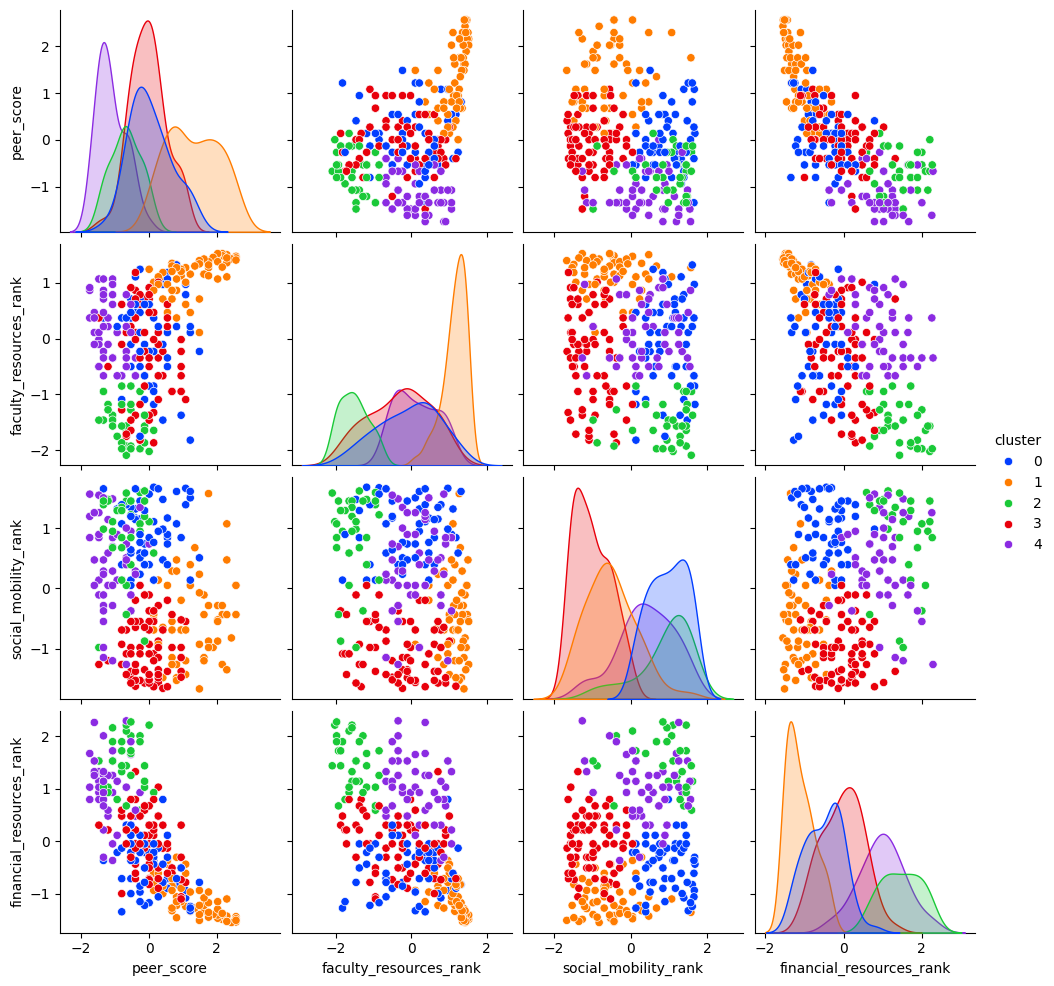

In [16]:

features = rank_df[['peer_score', 'faculty_resources_rank', 'social_mobility_rank', 'financial_resources_rank']]
features = features.dropna()

# normalize features
for col in features.columns:
    features[col] = (features[col] - features[col].mean()) / features[col].std()

kmeans = KMeans(n_clusters=5, random_state=42).fit(features)
features['cluster'] = kmeans.labels_

sns.pairplot(features, hue='cluster', palette='bright')
plt.show()


Some interesting correlations here:
- peer score and financial resources rank seem to be highly correlated
- faulty resources and financial resources also see roughly correlated
- high densities for groups 0 and 4

Cluster 0: schools with generally lower ranks across the features due to the spread and central tendency of points in the lower range.

Cluster 1: schools that perform well in terms of peer score but variably in other features.

Cluster 2: schools that have moderate to high rankings across all features.

Cluster 3: schools with high social mobility ranks but mixed in other areas.

Cluster 4:  high faculty resources and financial resources ranks but lower in peer scores and social mobility.

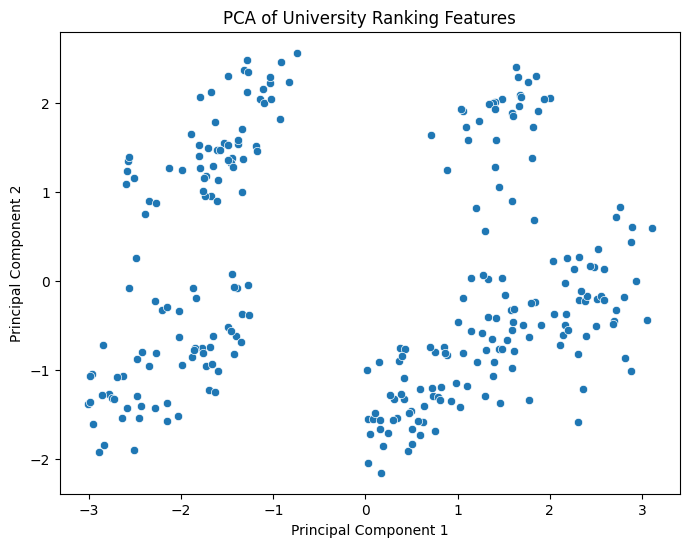

In [17]:

# reduce dimensionality of dataset seems like there are groups of universities with common characteristics
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

plt.figure(figsize=(8,6))
sns.scatterplot(x='principal component 1', y='principal component 2', data=principalDf)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of University Ranking Features')
plt.show()


In [18]:


# create a model to try and predict the ranking of a given unseen school

X = rank_df.drop(['school', 'rank', 'score'], axis=1)
y = rank_df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')

model = RandomForestRegressor(n_estimators=100, random_state=42)

# pipeline will first impute missing values then fit the model
pipeline = make_pipeline(imputer, model)

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)
print("Predictions:", predictions)

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)


Predictions: [55.71       31.42       64.72       39.17193623 45.6084     37.31391016
 37.31391016 48.66666667 90.9        49.93666667 45.37       29.92
 67.37       30.84       33.88       57.05       69.32       90.34
 32.15       33.62       51.42       34.59222222 29.34       51.19666667
 58.86       30.08       30.54       37.31391016 59.96       33.51
 71.6        58.94       28.09       48.48       60.68       38.65097676
 31.32       42.426875   42.3284     58.21       45.70176471 64.96
 31.95       44.72525    44.08153846 73.97       76.39       76.98
 28.27       44.26733333 34.30571429 57.31       85.88       37.02
 33.38       42.63       36.41975    35.68       90.5       ]
MSE: 13.098097368660804


Look at schools that have changed a lot and dig into why
sensitivity


In [19]:


# Preparing the data
X = rank_df.drop(['school', 'rank', 'score'], axis=1)
y = rank_df['score']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating an imputer object to fill missing values
imputer = SimpleImputer(strategy='median')  # Change strategy to 'median' for a different approach

# Creating a RandomForestRegressor model with hyperparameter tuning
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)

# Creating a pipeline that first imputes missing values then fits the model
pipeline = Pipeline([
    ('imputer', imputer),
    ('feature_selection', SelectFromModel(RandomForestRegressor(n_estimators=100))),
    ('regression', model)
])

# Grid Search for parameter tuning
param_grid = {
    'regression__n_estimators': [100, 200],
    'regression__max_depth': [None, 10, 20],
    'regression__min_samples_leaf': [1, 2, 4],
    'regression__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Predicting on the test data
predictions = best_model.predict(X_test)
print("Predictions:", predictions)

# Calculating Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)


Predictions: [58.08286254 30.78007774 69.40712897 43.69493927 42.64111089 39.68654199
 39.68654199 49.78623712 86.98439684 51.75581854 50.5917819  34.18990422
 64.03379885 33.18630137 38.66702201 58.05580302 73.96270391 83.72406452
 30.27453499 33.72132737 56.71944895 33.72132737 29.94471609 47.00556706
 62.77477976 28.77100108 29.804386   39.68654199 58.55147518 35.14806025
 75.60760073 58.05580302 30.27453499 49.78623712 58.55147518 44.77389412
 34.18990422 40.77775223 42.37919991 58.05580302 41.39323955 69.40712897
 34.18990422 42.37876701 43.69493927 86.19950193 75.1402793  73.96270391
 28.71731854 35.76578589 41.39323955 58.08286254 86.19950193 33.18630137
 33.72132737 35.76578589 34.65463528 37.8532554  83.72406452]
MSE: 34.123307592107075


Sophie - Ranking Sensitivity


In [20]:
HISTORICAL_RANKINGS_PATH = "/content/drive/MyDrive/6.S079_Project/data/us_news_rankings_2019_2024.csv"
rankings = pd.read_csv(HISTORICAL_RANKINGS_PATH)
display(rankings)

,College Name,State,IPEDS ID,2024,2023,2022,2021,2020,2019
0,Williams College,MA,168342,1,1,1,1,1,1
1,Amherst College,MA,164465,2,2,2,2,2,2
2,United States Naval Academy,MD,164155,3,6,6,6,17,22
3,Pomona College,CA,121345,4,3,4,4,5,5
4,Swarthmore College,PA,216287,4,4,3,3,3,3
...,...,...,...,...,...,...,...,...,...
372,William Peace University,NC,199272,NaN,NaN,NaN,NaN,NaN,T2 (173-229)
373,Williams Baptist University,AR,107877,NaN,NaN,T2 (168-222),T2 (171-221),T2 (164-215),NaN
374,Wingate University,NC,199962,NaN,NaN,NaN,NaN,NaN,NaN
375,Wisconsin Lutheran College,WI,240338,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:

def handle_rankings(rank):
    if pd.isna(rank):
        return None
    if isinstance(rank, str):
        # Use regular expressions to remove "T" followed by any digits
        rank = re.sub(r'T\d+', '', rank)
        if '-' in rank:
            low, high = rank.replace('(', '').replace(')', '').split('-')
            return (int(low) + int(high)) // 2 # replace ranges with medium number in the range
    return int(rank)

# Apply the function to all year columns
for year in ['2024', '2023', '2022', '2021', '2020', '2019']:
    rankings[year] = rankings[year].apply(handle_rankings)

# drop columns that don't have rankings for at least 2 of the years to compare
rankings['non_nan_count'] = rankings[['2019', '2020', '2021', '2022', '2023', '2024']].apply(lambda row: row.count(), axis=1)
df_filtered = rankings[rankings['non_nan_count'] >= 2]
df_filtered = df_filtered.drop(columns=['non_nan_count'])

# Print the filtered DataFrame
print(df_filtered)

# display(rankings)

# Calculate changes in rankings
df_filtered['Max Change'] = df_filtered.apply(
    lambda row: max(
        [abs(row[year] - row[str(int(year) + 1)])
         for year in ['2019', '2020', '2021', '2022']
         if not pd.isna(row[year]) and not pd.isna(row[str(int(year) + 1)])
        ], default=0  # Provide a default value here
    ), axis=1
)
# # Sort by the maximum change
df_sorted = df_filtered.sort_values(by='Max Change', ascending=False)

# # Print the top colleges with the largest changes
print(df_sorted[['College Name', 'State', '2019', '2020', '2021', '2022', '2023', '2024', 'Max Change']].head())

                         College Name State IPEDS ID  2024   2023   2022  \
0                    Williams College    MA   168342   1.0    1.0    1.0   
1                     Amherst College    MA   164465   2.0    2.0    2.0   
2         United States Naval Academy    MD   164155   3.0    6.0    6.0   
3                      Pomona College    CA   121345   4.0    3.0    4.0   
4                  Swarthmore College    PA   216287   4.0    4.0    3.0   
..                                ...   ...      ...   ...    ...    ...   
361            University of the West    CA   449870   NaN  178.0  195.0   
363  University of Wisconsin-Parkside    WI   240374   NaN    NaN  195.0   
364  University of Wisconsin-Superior    WI   240426   NaN    NaN  195.0   
367                  Wesleyan College    GA   141325   NaN    NaN  157.0   
373       Williams Baptist University    AR   107877   NaN    NaN  195.0   

      2021   2020   2019  
0      1.0    1.0    1.0  
1      2.0    2.0    2.0  
2     